# Introducing the Keras Functional API

**Learning objectives**

1. Understand embeddings and how to create them with the `feature_column` API
2. Understand deep and wide models and when to use them
3. Understand the Keras functional API and how to build a deep and wide model with it

## Introduction

The [Keras Functional API](https://www.tensorflow.org/guide/keras/sequential_model#functional_api) provides an alternate way of building models which is more flexible. With the Functional API, we can build models with more complex topologies, multiple input or output layers, shared layers or non-sequential data flows (e.g. residual layers).

In this notebook we'll use what we learned about feature columns to build a Wide & Deep model. Recall, that the idea behind Wide & Deep models is to join the two methods of learning through memorisation and generalisation by baking a wide linear model and a deep learning model to accommodate both. You can have a look at the original research paper here: [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

<img src="img/wide_deep.png" style="width:600px;height:150px;">

The Wide part of the model is associated with the memory element. In this case, we train a linear model with a wide set of crossed features and learn the correlation of this related data with the assigned label. The Deep part of the model is associated with the generalisation element where we use embedding vectors for features. The best embeddings are then learned through the training process. While both of these methods can work well alone, Wide & Deep models excel by combining these techniques together.

In [2]:
# Importing necessary modules/libraries such as NumPy, Pandas and datetime
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow import keras

from tensorflow import feature_column as fc

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, DenseFeatures, concatenate
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

2.4.1


## Load raw data

We will use the taxifare data set.

In [7]:
!ls -l data/taxi*

-rw-r--r-- 1 antounes antounes 123589 mars  16 18:20 data/taxi-test.csv
-rw-r--r-- 1 antounes antounes 579054 mars  16 18:21 data/taxi-train.csv
-rw-rw-r-- 1 antounes antounes 123113 mars  16 18:21 data/taxi-valid.csv


## Use `tf.data` to read the CSV files

For this lab, we will include some engineered features in our model. In particular, we will compute the difference in latitude and longitude, as well as the Euclidean distance between the pick-up and drop-off locations. We can accomplish this by adding these new features to the features dictionary with the function `add_engineered_features` below.

Note that we include a call to this function when collecting our features and labels `dict` in the `features_and_labels` function below as well.

In [17]:
# Selecting specific CSV_COLUMNS, LABEL_COLUMN, DEFAULTS, UNWANTED_COLS
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key"
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], "na", [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]

# Create an input function reading a file using the `tf.data.Dataset` API
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)
    
    return features, label

# Reading CSV files into a `tf.data.Dataset`
def create_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)
    
    dataset = dataset.map(features_and_labels)
    
    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    
    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Feature columns for Wide and Deep model

For the Wide columns, we will create feature columns of crossed features. To do this we'll create a collection of TensorFlow feature columns to pass to the `tf.feature_column.crossed_column` constructor. The Deep columns will consist of numeric columns and the embedding columns we want to create

In [9]:
# Bucketise latitudes and longitudes
NBUCKETS = 16
latbuckets = np.linspace(start=38.0, stop=42.0, num=NBUCKETS).tolist()
lonbuckets = np.linspace(start=-76.0, stop=-72.0, num=NBUCKETS).tolist()

fc_bucketized_plat = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column("pickup_latitude"), boundaries=latbuckets)
fc_bucketized_plon = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column("pickup_longitude"), boundaries=lonbuckets)
fc_bucketized_dlat = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column("dropoff_latitude"), boundaries=latbuckets)
fc_bucketized_dlon = tf.feature_column.bucketized_column(
    source_column=tf.feature_column.numeric_column("dropoff_longitude"), boundaries=lonbuckets)

# Cross features for locations
fc_crossed_dloc = tf.feature_column.crossed_column(
    [fc_bucketized_dlat, fc_bucketized_dlon],
    hash_bucket_size=NBUCKETS*NBUCKETS)
fc_crossed_ploc = tf.feature_column.crossed_column(
    [fc_bucketized_plat, fc_bucketized_plon],
    hash_bucket_size=NBUCKETS*NBUCKETS)
fc_crossed_pd_pair = tf.feature_column.crossed_column(
    [fc_crossed_dloc, fc_crossed_ploc],
    hash_bucket_size=NBUCKETS**4)

# Create embedding columns for the crossed columns
fc_pd_pair = tf.feature_column.embedding_column(categorical_column=fc_crossed_pd_pair, dimension=3)
fc_dloc = tf.feature_column.embedding_column(categorical_column=fc_crossed_dloc, dimension=3)
fc_ploc = tf.feature_column.embedding_column(categorical_column=fc_crossed_ploc, dimension=3)

## Gather list of feature columns

Next we gather the list of wide and deep feature columns we'll pass to our Wide & Deep model in TensorFlow. Recall, wide columns are sparse, have linear relationship with the output while deep columns are dense and have a complex relationship with the output. We will use our previously bucketised columns to collect crossed feature columns and sparse feature columns for our wide columns, and embedding feature columns and numeric feature columns for the deep columns.

In [10]:
wide_columns = [
    # One-hot encoded feature crosses
    tf.feature_column.indicator_column(fc_crossed_dloc),
    tf.feature_column.indicator_column(fc_crossed_ploc),
    tf.feature_column.indicator_column(fc_crossed_pd_pair)
]

deep_columns = [
    # Embedding column to "group" together
    tf.feature_column.embedding_column(fc_crossed_pd_pair, dimension=10),
    # Numeric columns
    tf.feature_column.numeric_column("pickup_latitude"),
    tf.feature_column.numeric_column("pickup_longitude"),
    tf.feature_column.numeric_column("dropoff_longitude"),
    tf.feature_column.numeric_column("dropoff_latitude")
]

## Build a Wide & Deep model in Keras

To build a Wide & Deep network, we connect the sparse (i.e. wide) features directly to the output node, but pass the dense (i.e. deep) features through a set of fully connected layers. Here's what the model architecture looks like using the Functional API.

First, we'll create our input columns using `tf.keras.layers.Input`

In [11]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count"
]

inputs = {
    colname: tf.keras.layers.Input(name=colname, shape=(), dtype="float32")
    for colname in INPUT_COLS
}

Then, we'll define our custom RMSE evaluation metric and build our Wide & Deep model.

In [14]:
# Here, `tf.reduce_mean` computes the mean of the elements across the dimensions of a tensor
# `tf.sqrt` computes element-wise square root of the input tensor
# `tf.square` computes element-wise square of input tensor
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_model(dnn_hidden_units):
    # Create the Deep part of the model
    deep = tf.keras.layers.DenseFeatures(deep_columns, name="deep_inputs")(inputs)
    for num_nodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(num_nodes, activation="relu")(deep)
    
    # Create the Wide part of the model
    wide = tf.keras.layers.DenseFeatures(wide_columns, name="wide_inputs")(inputs)
    
    # Combine deep and wide parts of the model
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name="combined")
    
    # Map the combined outputs into a single prediction value
    output = tf.keras.layers.Dense(units=1, activation=None, name="prediction")(combined)
    
    # Finalise the model
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    
    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers, each with $10$ neurons, for the deep part of our model. We can also use `plot_model` to see a diagram of the model we've created.

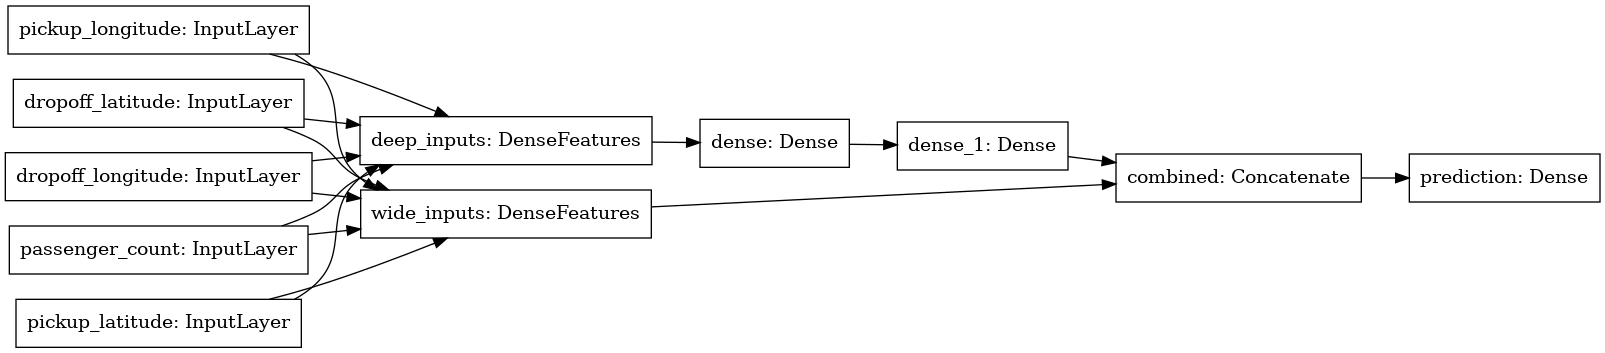

In [15]:
HIDDEN_UNITS = [10, 10]

# Calling the `build_model`
model = build_model(dnn_hidden_units=HIDDEN_UNITS)

# Converts a Keras `plot_model` to see a diagram of the model that we have created
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

Next, we'll set up our training variables, create our data sets for training and validation, and train our model. 

(We could refer to the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for futher details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.)

In [18]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5 # Training data set will repeat, wrap around
NUM_EVALS = 50 # How many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # Enough to get a reasonable sample

trainds = create_dataset(
    pattern="data/taxi-train*",
    batch_size=BATCH_SIZE,
    mode="train")

evalds = create_dataset(
    pattern="data/taxi-valid*",
    batch_size=BATCH_SIZE,
    mode="eval").take(NUM_EVAL_EXAMPLES//1000)

In [19]:
%%time
# Here, %%time prints the wall time for the entire cell
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

OUTDIR = "data/taxi_trained"
shutil.rmtree(path=OUTDIR, ignore_errors=True) # Start fresh each time

history = model.fit(x=trainds,
                   steps_per_epoch=steps_per_epoch,
                   epochs=NUM_EVALS,
                   validation_data=evalds,
                   callbacks=[TensorBoard(OUTDIR)])

Epoch 1/50
1/1 [==============================] - 34s 34s/step - loss: 228.6106 - rmse: 15.1199 - mse: 228.6106 - val_loss: 248.9886 - val_rmse: 15.7705 - val_mse: 248.9886
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 232.6816 - rmse: 15.2539 - mse: 232.6816 - val_loss: 247.2655 - val_rmse: 15.7133 - val_mse: 247.2655
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 280.0049 - rmse: 16.7333 - mse: 280.0049 - val_loss: 245.4750 - val_rmse: 15.6553 - val_mse: 245.4750
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 231.5777 - rmse: 15.2177 - mse: 231.5777 - val_loss: 243.4854 - val_rmse: 15.5961 - val_mse: 243.4854
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 232.0846 - rmse: 15.2343 - mse: 232.0846 - val_loss: 237.5916 - val_rmse: 15.3992 - val_mse: 237.5916
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 239.7457 - rmse: 15.4837 - mse: 239.7457 - val_loss: 239.6061 - val_rmse: 

Epoch 49/50
1/1 [==============================] - 4s 4s/step - loss: 138.3538 - rmse: 11.7624 - mse: 138.3538 - val_loss: 140.0558 - val_rmse: 11.8233 - val_mse: 140.0558
Epoch 50/50
1/1 [==============================] - 4s 4s/step - loss: 119.9777 - rmse: 10.9534 - mse: 119.9777 - val_loss: 138.0844 - val_rmse: 11.7314 - val_mse: 138.0844
CPU times: user 4min 15s, sys: 3min 58s, total: 8min 13s
Wall time: 3min 23s


We can examine the history to see how the RMSE changes through training on the train set and validation set.

<AxesSubplot:>

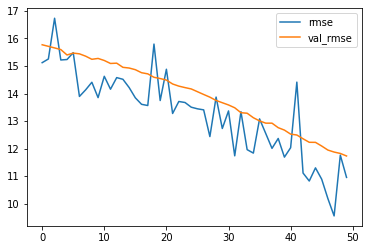

In [20]:
RMSE_COLS = ["rmse", "val_rmse"]

# Pandas DataFrame is a two-dimensional size-mutable, potentially heterogeneous tabular data structure 
# with labeled axes (rows and columns)
pd.DataFrame(history.history)[RMSE_COLS].plot()